# Lesson 1 - What's your pet
# With 1 more layer at the input to reduce the number of channels to 3

This notebook shows how to modify [learner.py](https://github.com/fastai/fastai/blob/master/fastai/vision/learner.py) to a new file learner_xc_to_3c.py (learner x channels to 3 channels) **to put a ConvNet in a fastai cnn_learner() before the pre-trained model like resnet** (followed by a normalization by imagenet_stats).

**This ConvNet as first layer allows to transform any images of the dataloader with n channels to an image with 3 channels.** During the training, the filters of this ConvNet as first layer will be learnt. 

Thanks to that, it is possible to go on using fastai Transfer Learning functions even with images with more than 3 channels RGB like satellite images. 

## Warning

As the Oxford IIIT Pet dataset already has 3 channels by image, there is no need here to change this number of channels. 

We only used this dataset to create our code. However, **it would be more interesting to apply this code to images with more than 3 channels like images with 16 channels** of the [Dstl Satellite Imagery Feature Detection](https://www.kaggle.com/c/dstl-satellite-imagery-feature-detection/).

## Initialisation

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.metrics import error_rate

In [3]:
# batch size
bs = 64
# bs = 16   # uncomment this line if you run out of memory even after clicking Kernel->Restart

# images size in dataloader
size = 224 

# number of channels of the dataset images
n_channels = 3

## Databunch

In [4]:
path = untar_data(URLs.PETS); path
path.ls()

[WindowsPath('D:/fastai/data/oxford-iiit-pet/annotations'),
 WindowsPath('D:/fastai/data/oxford-iiit-pet/crappy'),
 WindowsPath('D:/fastai/data/oxford-iiit-pet/images'),
 WindowsPath('D:/fastai/data/oxford-iiit-pet/image_gen'),
 WindowsPath('D:/fastai/data/oxford-iiit-pet/models'),
 WindowsPath('D:/fastai/data/oxford-iiit-pet/other'),
 WindowsPath('D:/fastai/data/oxford-iiit-pet/small-256'),
 WindowsPath('D:/fastai/data/oxford-iiit-pet/small-96'),
 WindowsPath('D:/fastai/data/oxford-iiit-pet/test')]

In [5]:
# get path to all data
path_img = path/'images'
fnames = get_image_files(path_img)
fnames[:5]

[WindowsPath('D:/fastai/data/oxford-iiit-pet/images/Abyssinian_1.jpg'),
 WindowsPath('D:/fastai/data/oxford-iiit-pet/images/Abyssinian_10.jpg'),
 WindowsPath('D:/fastai/data/oxford-iiit-pet/images/Abyssinian_100.jpg'),
 WindowsPath('D:/fastai/data/oxford-iiit-pet/images/Abyssinian_101.jpg'),
 WindowsPath('D:/fastai/data/oxford-iiit-pet/images/Abyssinian_102.jpg')]

In [6]:
# get mean,std by channel of the dataset
mean = torch.zeros(n_channels)
std = torch.zeros(n_channels)
n_pixels = torch.zeros(n_channels)

for fname in fnames:
    img = open_image(fname)
    for i in range(n_channels):
        mean[i] += img.data[i].sum()
        n_pixels[i] += img.shape[1]*img.shape[2]

mean = mean / n_pixels

for fname in fnames:
    img = open_image(fname)
    for i in range(n_channels):
#         import pdb; pdb.set_trace()
        std[i] += ((img.data[i] - mean[i])**2).sum()
        
std = torch.sqrt(std / n_pixels)

In [7]:
mean,std

(tensor([0.4814, 0.4484, 0.3949]), tensor([0.2693, 0.2648, 0.2728]))

In [8]:
np.random.seed(2)
pat = r'/([^/]+)_\d+.jpg$'

# normalize images with mean and std 
# (keep the imagenet_stats normalization for the 3 channels images after the ConvNet transformation)
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(), size=size, bs=bs
                                  ).normalize((mean,std))

## (experimentation) ConvNet to transform an image with n_channels to one with 3 channels

In [9]:
# model
xc_to_3c = nn.Conv2d(n_channels, 3, kernel_size=3, stride=1, padding=1)
xc_to_3c.cuda()

for xb, yb in data.train_dl:
    out = (xc_to_3c(*[xb]))
    print(out.size())
    break

torch.Size([64, 3, 224, 224])


In [10]:
# number of parameters
sum([p.numel() for p in xc_to_3c.parameters()])

84

In our dataset, our images already have 3 channels. Therefore, the number of parameters of a filter is 3x3x3 = 27. As there are 3 channels at the output of the ConvNet, there are 27x3 = 81 parameters. At last, you need to add the 3 biases (1 by filter). Then, you get 84 parameters.

If the number of channels of the dataset images was 10 for example, the number of parameters of our Convnet would be:
(3x3x10) x 3 + 3 = 273

## Training (resnet34) | ConvNet with kernel_size = 3

In [97]:
# import the learner cnn_learner_xc_to_3c which has a ConvNet at first layer to convert images with n_channels to 3 channels
from learner_xc_to_3c import cnn_learner_xc_to_3c # x channels to 3 channels

In [200]:
n_channels = 3 # put here the number of channels of the images in your dataset
learn = cnn_learner_xc_to_3c(data, models.resnet34, n_channels, kernel_size=3, padding=1, metrics=error_rate)

In [99]:
# make learnable parameters of the first layer (xc_to_3c)
for param in learn.model[0].parameters():
    param.requires_grad = True

In [100]:
learn.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [3, 224, 224]        84         True      
______________________________________________________________________
Normalize            [3, 224, 224]        0          False     
______________________________________________________________________
Conv2d               [64, 112, 112]       9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 112, 112]       128        True      
______________________________________________________________________
ReLU                 [64, 112, 112]       0          False     
______________________________________________________________________
MaxPool2d            [64, 56, 56]         0          False     
______________________________________________________________________
Conv2d               [64, 56, 56]         36,864     False     
___________________________________________________

In [15]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.570876,0.537090,0.148173,01:48
1,0.754445,0.404227,0.123139,01:49
2,0.520328,0.363664,0.117050,01:49
3,0.393615,0.344019,0.106225,01:52


In [16]:
learn.save('pets1')

### Unfreezing, fine-tuning, and learning rates

In [17]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


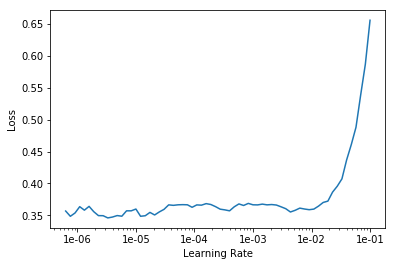

In [18]:
learn.recorder.plot()

In [19]:
learn.unfreeze()
learn.fit_one_cycle(4, max_lr=slice(1e-5,1e-3))

epoch,train_loss,valid_loss,error_rate,time
0,0.391076,0.431243,0.137348,01:53
1,0.378269,0.369823,0.114344,01:54
2,0.258467,0.282621,0.085927,01:56
3,0.147830,0.273601,0.087280,01:55


In [20]:
learn.save('pets2')

### Matrix of images channels reduction 

In [201]:
learn.load('pets2');

In [207]:
for param in learn.model[0].parameters():
    print(param, param.shape)

Parameter containing:
tensor([[[[ 0.0756, -0.0391,  0.0349],
          [ 0.1093, -0.0471, -0.1488],
          [-0.0374, -0.0585, -0.1315]],

         [[-0.1481, -0.0872,  0.1794],
          [ 0.0679,  0.0402,  0.1462],
          [ 0.1080,  0.0680, -0.1000]],

         [[ 0.0924,  0.0439,  0.0812],
          [ 0.0503,  0.0872,  0.1691],
          [ 0.1915,  0.1335, -0.1701]]],


        [[[-0.1345, -0.0311, -0.1382],
          [ 0.0738, -0.0552, -0.0025],
          [-0.0089, -0.1106, -0.0421]],

         [[-0.1181,  0.0038,  0.1914],
          [ 0.1135,  0.1866,  0.0166],
          [ 0.1273,  0.0403,  0.1156]],

         [[-0.0383,  0.0830,  0.0716],
          [ 0.1667,  0.1751, -0.1383],
          [ 0.1693, -0.0877, -0.0852]]],


        [[[ 0.1262, -0.0094, -0.1921],
          [ 0.1068,  0.0557,  0.0487],
          [-0.1257,  0.0778,  0.1068]],

         [[-0.0007, -0.1265,  0.0768],
          [-0.1567, -0.0843,  0.0776],
          [ 0.0430,  0.1393, -0.0110]],

         [[-0.0448,  0

In [203]:
for xb, yb in data.train_dl:
#     out = learn.model[1](learn.model[0](*[xb]))
    out = learn.model[0](*[xb])
    print(out.size())
    break

torch.Size([64, 3, 224, 224])


In [204]:
# Show Image
def show_image(x, stats=[mean,std], dl_img=True):
    
    mean, std = stats[0], stats[1]
    img = torch.zeros_like(x)

    # Denormalize the image
    for i in range(x.size(0)):
        img[i] = x[i] * std[i] + mean[i]
        
    # Convert image to numpy
    if not dl_img:
        img = torch.clamp(img, min=0., max=1.)
    img_numpy = img.detach().cpu().numpy()
    
    # Print the image
    fig = plt.figure(figsize=(25, 4))
    plt.imshow(np.transpose(img_numpy, (1, 2, 0)))

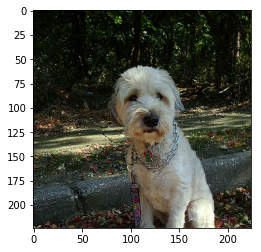

In [205]:
# image from the dataloader
show_image(xb[0])

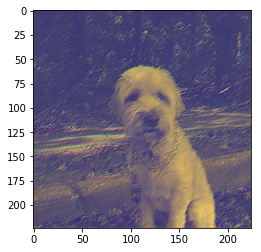

In [206]:
# image calculated by our ConvNet as first layer (parameters learnt by training)
show_image(out[0], dl_img=False)

## Training (resnet34) | ConvNet with kernel_size = 1

In [101]:
# import the learner cnn_learner_xc_to_3c which has a ConvNet at first layer to convert images with n_channels to 3 channels
from learner_xc_to_3c import cnn_learner_xc_to_3c # x channels to 3 channels

In [208]:
n_channels = 3 # put here the number of channels of the images in your dataset
learn = cnn_learner_xc_to_3c(data, models.resnet34, n_channels, kernel_size=1, padding=0, metrics=error_rate)

In [103]:
# make learnable parameters of the first layer (xc_to_3c)
for param in learn.model[0].parameters():
    param.requires_grad = True

In [104]:
learn.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [3, 224, 224]        12         True      
______________________________________________________________________
Normalize            [3, 224, 224]        0          False     
______________________________________________________________________
Conv2d               [64, 112, 112]       9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 112, 112]       128        True      
______________________________________________________________________
ReLU                 [64, 112, 112]       0          False     
______________________________________________________________________
MaxPool2d            [64, 56, 56]         0          False     
______________________________________________________________________
Conv2d               [64, 56, 56]         36,864     False     
___________________________________________________

In [105]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.874340,0.803331,0.237483,02:06
1,0.966122,0.547294,0.186739,01:51
2,0.661154,0.460992,0.165765,01:55
3,0.505825,0.450824,0.160352,01:50


In [106]:
learn.save('pets1_kz0')

### Unfreezing, fine-tuning, and learning rates

In [107]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


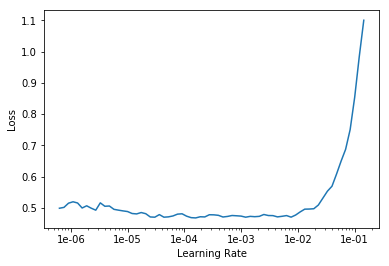

In [108]:
learn.recorder.plot()

In [109]:
learn.unfreeze()
learn.fit_one_cycle(4, max_lr=slice(1e-5,1e-3))

epoch,train_loss,valid_loss,error_rate,time
0,0.488661,0.427515,0.146143,01:52
1,0.433929,0.396560,0.140054,01:53
2,0.277930,0.318978,0.101489,01:54
3,0.172929,0.294749,0.091340,01:54


In [110]:
learn.save('pets2_kz0')

### Matrix of images channels reduction 

In [209]:
learn.load('pets2_kz0');

In [210]:
for param in learn.model[0].parameters():
    print(param, param.shape)

Parameter containing:
tensor([[[[-0.5518]],

         [[-0.1051]],

         [[-0.4610]]],


        [[[-0.5105]],

         [[ 0.3119]],

         [[-0.3760]]],


        [[[ 0.5178]],

         [[ 0.0929]],

         [[-0.3057]]]], device='cuda:0') torch.Size([3, 3, 1, 1])
Parameter containing:
tensor([ 0.0453, -0.1729, -0.5115], device='cuda:0') torch.Size([3])


In [190]:
for xb, yb in data.train_dl:
#     out = learn.model[1](learn.model[0](*[xb]))
    out = learn.model[0](*[xb])
    print(out.size())
    break

torch.Size([64, 3, 224, 224])


In [191]:
# Show Image
def show_image(x, stats=[mean,std], dl_img=True):
    
    mean, std = stats[0], stats[1]
    img = torch.zeros_like(x)

    # Denormalize the image
    for i in range(x.size(0)):
        img[i] = x[i] * std[i] + mean[i]
        
    # Convert image to numpy
    if not dl_img:
        img = torch.clamp(img, min=0., max=1.)
    img_numpy = img.detach().cpu().numpy()
    
    # Print the image
    fig = plt.figure(figsize=(25, 4))
    plt.imshow(np.transpose(img_numpy, (1, 2, 0)))

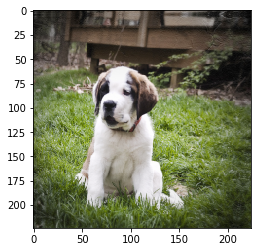

In [198]:
# image from the dataloader
show_image(xb[0])

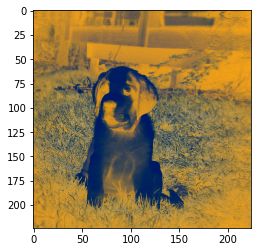

In [199]:
# image calculated by our ConvNet as first layer (parameters learnt by training)
show_image(out[0], dl_img=False)

## END